# Ejemplo movimiento del auto

El movimiento del auto esta dado por la siguiente matriz de estados:

$$
\underline{X_{k+1}} = \begin{bmatrix} x_k + v_k\Delta t + \frac{1}{2}a\Delta t^2 \\ v_k + a\Delta t \end{bmatrix}

$$

Lo podemos reescribir como:
$$
\underline{X_{k+1}} = \begin{bmatrix} 1 & \Delta t \\ 0 & 1\end{bmatrix} \underline{X_k} + \begin{bmatrix} \frac{1}{2}\Delta t^2 \\ \Delta t\end{bmatrix}a \quad a=N(0, \sigma_a^2)
$$
Donde a representa el error del sistema

Luego observamos la medicion del sistema (un gps o juan mirando el autito) y lo escribimos como  

$$
\underline{Z_{k+1}} = \begin{bmatrix} 1 & 0 \end{bmatrix}\underline{X_k} + \epsilon_k 
$$

Donde $\epsilon_k$ representa el error de medicion de Juan

Ahora llamamos: 

$$
F = \begin{bmatrix} 1 & \Delta t \\ 0 & 1\end{bmatrix} \underline{X_k} 
$$
$$
G = \begin{bmatrix} \frac{1}{2}\Delta t^2 \\ \Delta t\end{bmatrix}
$$
$$
H = \begin{bmatrix} 1 & 0 \end{bmatrix}
$$

Reescribo el funcionamiento del sistema como:
$$
\underline{X_{k+1}} = F\underline{X_k} + Ga
$$

$$
\underline{Z_{k+1}} = H\underline{X_k} + \epsilon_k
$$

Donde el primero representa lo medido + el error interno del sistema y el segundo lo observado + el error del sistema de obvservación

Una vez que tengo estas definciones ya puedo calcular la posicion posta utilizando el filtro de kalman 

Para eso primero tengo que definir: $\underline{X_0}$  $\sigma_a$  $\epsilon_k$ $P_0$ donde P es la matriz de covarianza del sistema que relaciona la correlación de los errores de medición con los de obvservación 

También definimos la matriz G, pero ya directo lo escribimos como $Q = GaG^T$ que es lo que después vamos a usar

In [2]:
import numpy as np
import matplotlib.pyplot as plt
# estado inicial
x_pos = 0
x_vel = 0.2
tiempo = 100

R = 1               # ruído de las mediciones
ruido_proceso = 0.2 # ruído del proceso

Q = np.array([[ruido_proceso,0],[0,0]])      # = GaG.T  
P = np.eye(2)   # matriz de covarianza inicial

x_hat = np.array([x_pos, x_vel])
F = np.array([[1, 1], [0, 1]]) # matriz de transición de estados
H = np.array([[1, 0]])         # matriz de observación

Ahora creamos $ \underline{X}$ y $ \underline{Z} $ que serían los arreglos del los estados y las mediciones con ruido para todos los tiempors

In [3]:
x = np.array([[x_vel * t + np.random.normal(0, ruido_proceso), x_vel] for t in range(tiempo)])  # estado real del sistema (esto en realidad no lo sabemos)

# mediciones del gps (tienen ruido)
mediciones = [i[0] + np.random.normal(0, R) for i in x]  # mediciones de un sensor con ruido (en este caso el gps)

### Filtro dado el sistema, sus condiciones iniciales definidas y la trayectoria simulada

loop que itere por cada instante de tiempo que hace los siguientes pasos:

Paso 1: hago mis predicciones a priori y busco el error del sistema

Calculo $\hat{\underline{X}}_{k+1}^´$ = $F\underline{X_k}$ que es mi prediccion teorica a priori en el tiempo k+1

Calculo $P_{k+1}$ = $FP_kF^T + Q$ que es la matriz de covarianza del sistema en el tiempo k+1 y esta la voy a ir corrigiendo

Paso 2: calculo K que representa la ganancia de Kalman

$S_k = HP_kH^T + \sigma_a^2$

$K_k = P_kH^TS_k^{-1}$

Paso 3: Mirando la diferencia entre mi prediccion a priori y mi medicón hago una nueva predicción que también utiliza la ganancia de kalman que acabo de calcular y actualizo la matriz de covarianza del sistema (con esta nueva información) para que en el siguiente paso le erre por menos al estado real

$\hat{\underline{X}}_{k+1} = \hat{\underline{X}}_{k+1}^´ + K \underline{Z_k}- H\hat{\underline{X}}_{k}^´$

$P_{k+1} = (I - KH)P_k$

Ahora ya tengo mi posición filtrada por el filtro de kalman que es la que uso


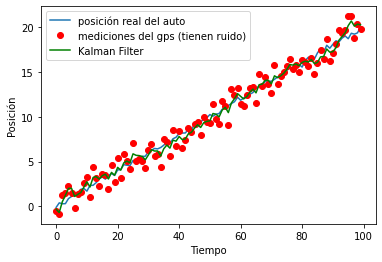

In [4]:
Kalman_gains = []
kalman_filter = []
for z in mediciones:
    # Projection into K+1
    x_hat_tick_plus_one = F.dot(x_hat) 
    P_tick = F.dot(P).dot(F.T) + Q 

    #Kalman gain
    _s = H.dot(P_tick).dot(H.T) + R
    K = P_tick.dot(H.T).dot(np.linalg.inv(_s))
    #update estimate
    x_hat = x_hat_tick_plus_one + K.dot(z - H.dot(x_hat_tick_plus_one)) 
    #update covariance
    P = (np.eye(2) - K.dot(H)).dot(P_tick)
    Kalman_gains.append(K[0])
    kalman_filter.append(x_hat[0])

# Plot the results
plt.plot(x[:, 0], label='posición real del auto')
plt.plot(mediciones, 'ro', label='mediciones del gps (tienen ruido)')
plt.plot(kalman_filter[:], 'g-', label='Kalman Filter')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Posición')
plt.show()